# Transport optimal

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## Images

In [2]:
def PIL_to_array(img_file_path):
    img = Image.open(img_file_path)
    img = np.array(img, dtype=np.uint8)
    return img

def crop(img, crop_width, crop_height):
    height, width, _ = img.shape
    start_height = crop_height // 2
    end_height   = height - crop_height // 2

    start_width  = crop_width // 2
    end_width    = width - crop_width // 2

    return img[start_height:end_height, start_width:end_width,  :]

Size of first image: (20, 21, 3)
Size of second image: (20, 21, 3)


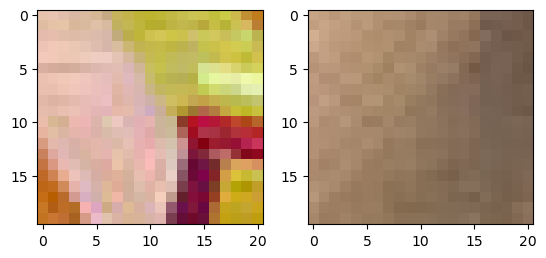

In [3]:
img_file_path = "delaunay.jpeg"
delaunay = PIL_to_array(img_file_path)[:480,:,:]
crop_height = 460
crop_width = 275
delaunay = crop(delaunay, crop_width, crop_height)
print("Size of first image:", delaunay.shape)

img_file_path = "vermer.jpeg"
vermer = PIL_to_array(img_file_path)
crop_width = vermer.shape[1] - delaunay.shape[1]
vermer = crop(vermer, crop_width, crop_height)
print("Size of second image:", vermer.shape)

# Plot figure
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.imshow(delaunay)
ax1.imshow(vermer)
plt.show()


## Utils

In [4]:
import math
from pulp import *

In [5]:
def get_cost_matrix(img1, img2):

    height, width, _ = img1.shape

    res = np.zeros((height * width, height * width), dtype=np.float16)
    row_idx = 0

    for line1 in img1:
        for pix1 in line1:
            col_idx = 0
            for line2 in img2:
                for pix2 in line2:
                    res[row_idx, col_idx] = math.dist(pix1, pix2)
                    col_idx += 1
            row_idx += 1

    return res

In [6]:
def optimal_solve(costs, m_start, m_arrival):
  
  # Initialise les variables du problème
  problem = LpProblem("Optimal_transport", LpMinimize)
  paths = [(i, j) for i in range(len(m_start)) for j in range(len(m_arrival))]
  
  path_variables = LpVariable.dicts("Path", (range(len(m_start)), range(len(m_arrival))),
                                lowBound=0, cat='Integer')

  # Définit la fonction objective
  problem += lpSum([path_variables[i][j] * costs[i][j] for (i, j) in paths])

  # Pose les contraintes
  for i in range(len(m_start)):
      problem += lpSum([path_variables[i][j] for j in range(len(m_arrival))]) == m_start[i]
  #print(problem)
  for j in range(len(m_arrival)):
      problem += lpSum([path_variables[i][j] for i in range(len(m_start))]) == m_arrival[j]

  problem.solve()

  result = {}
  for v in problem.variables():
      route = v.name.split("_")[1:]
      i, j = int(route[0]), int(route[1])
      result[i, j] = v.varValue

  optimal_plane = np.zeros((len(m_start), len(m_arrival)))
  for i, j in result.keys():
    optimal_plane[i,j] = result[i, j]

  #print(f"Plan de transport optimal :\n{optimal_plane}")  
  #print(problem.objective)
  #print(f"Coût minimal: {value(problem.objective)}")
  return optimal_plane

In [7]:
costs = get_cost_matrix(delaunay, vermer)

In [8]:
m_start = [1 for i in range(vermer.shape[0] * vermer.shape[1])]
m_end   = [1 for i in range(delaunay.shape[0] * delaunay.shape[1])]

optimal_plane = optimal_solve(costs, m_start, m_end)

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Dec  8 2020 

command line - cbc /tmp/0a7610668a0646b390b86c7dd9c3e26e-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/0a7610668a0646b390b86c7dd9c3e26e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 845 COLUMNS
At line 882846 RHS
At line 883687 BOUNDS
At line 1060088 ENDATA
Problem MODEL has 840 rows, 176400 columns and 352800 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 39329.8 - 3.06 seconds
Cgl0004I processed model has 840 rows, 176400 columns (176400 integer (176400 of which binary)) and 352800 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 39329.8
Cbc0038I Before mini branch and bound, 176400 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (6.33 seconds)
Cbc0038I After 6.33 seconds - Feasibility pum

In [9]:
print(optimal_plane)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
def get_coordinates(coordinates, matrix_width):
    return (coordinates // matrix_width, coordinates % matrix_width)

In [11]:
def new_image(optimal_plane, img_source):
    
    img_res = np.zeros_like(img_source, dtype=np.uint8)
    matrix_width = img_res.shape[1]
    args = np.argwhere(optimal_plane == 1)
    for start_pixel, end_pixel in args:
        x, y = get_coordinates(start_pixel, matrix_width)
        w, z = get_coordinates(end_pixel, matrix_width)
        img_res[x][y] = img_source[w][z]
    return img_res

In [12]:
recolored_image = new_image(optimal_plane, delaunay)

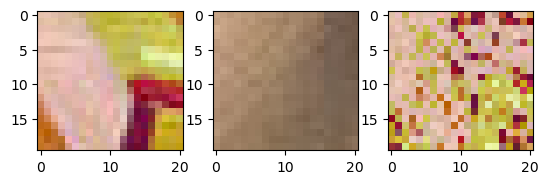

In [13]:
# Plot figure
fig, (ax0, ax1, ax2) = plt.subplots(1,3)
ax0.imshow(delaunay)
ax1.imshow(vermer)
ax2.imshow(recolored_image)
plt.show()